In [1]:
import os
import requests

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns
import geopandas as gpd
import earthpy as et
import xarray as xr
import regionmask
from metpy.plots.declarative import (MapPanel,PlotObs,PanelContainer,ContourPlot,FilledContourPlot)
from datetime import datetime, timedelta

sns.set(font_scale=1.3)
sns.set_style("white")

In [2]:
# Get netcdf file

prcp_data_path = 'http://weather.eas.cmich.edu:8080/repository/opendap/08b17143-0623-4088-9c1c-32c2d5e58f93/entry.das'

# Open up the data

with xr.open_dataset(prcp_data_path) as file_nc:
    daily_prcp_xr = file_nc

# View xarray object

daily_prcp_xr

<xarray.Dataset>
Dimensions:  (lat: 120, lon: 300, time: 26943)
Coordinates:
  * lon      (lon) float32 230.1 230.4 230.6 230.9 ... 304.1 304.4 304.6 304.9
  * lat      (lat) float32 20.12 20.38 20.62 20.88 ... 49.12 49.38 49.62 49.88
  * time     (time) datetime64[ns] 1948-01-01 1948-01-02 ... 2021-10-06
Data variables:
    precip   (time, lat, lon) float32 ...
Attributes:
    title:             CPC Unified Gauge-Based Analysis of Daily Precipitatio...
    Conventions:       COARDS
    description:       Gridded daily Precipitation
    platform:          Observations
    Comments:          Preciptation is accumulated from 12z of previous day t...
    history:           originally created V1.0 starting 04/2010 by CAS from d...
    dataset_title:     CPC Unified Gauge-Based Analysis of Daily Precipitatio...
    References:        http://www.psl.noaa.gov/data/gridded/data.unified.dail...
    _CoordSysBuilder:  ucar.nc2.dataset.conv.COARDSConvention

In [3]:
# Download natural earth data which contains state boundaries to generate area of interest

et.data.get_data(
    url="https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_1_states_provinces_lakes.zip")

# Go to where data was downloaded

os.chdir(os.path.join(et.io.HOME, "earth-analytics"))

states_path = "earthpy-downloads/ne_50m_admin_1_states_provinces_lakes"
states_path = os.path.join( "data",
    states_path, "ne_50m_admin_1_states_provinces_lakes.shp")

#Read in the states using the GeoPandas package

states_gdf = gpd.read_file(states_path)

In [4]:
# Select the state of Michigan from the natural earth data

mi_aoi = states_gdf[states_gdf.name == "Michigan"]

# Print the total spatial extent for Michigan (west_lon, south_lat, east_lon, north_lat)

mi_aoi.total_bounds

array([-90.41258814,  41.70143447, -82.41723144,  48.17592773])

In [5]:
# Separate the lats from the lons
# Notice that the longitude values have negative numbers

aoi_lat = [float(mi_aoi.total_bounds[1]), float(mi_aoi.total_bounds[3])]
aoi_lon = [float(mi_aoi.total_bounds[0]), float(mi_aoi.total_bounds[2])]

aoi_lat, aoi_lon

([41.701434467279654, 48.175927734374994],
 [-90.41258813514587, -82.41723144155574])

In [6]:
# The precip files use a global lat/lon so adjust values accordingly
# You can see the precip files lat/lon range when you viewed the xarray object above 

aoi_lon[0] = aoi_lon[0] + 360
aoi_lon[1] = aoi_lon[1] + 360

In [7]:
# Specify the time you want 

date = "2019-07-20"
date_obj = datetime.strptime(date, '%Y-%m-%d')
tlist = [date_obj]

In [8]:
#Find the points in the precip data that are inside Michigan
#Use them to create a mask

mi_mask = regionmask.mask_3D_geopandas(mi_aoi,
                                         daily_prcp_xr.lon,
                                        daily_prcp_xr.lat)

In [9]:
#Create a new data array that includes only the precip data over Michigan for the specified time

prcp_masked = daily_prcp_xr["precip"].sel(time=date, 
                                              lon=slice(aoi_lon[0], aoi_lon[1]), 
                                              lat=slice(aoi_lat[0], aoi_lat[1])).where(mi_mask)

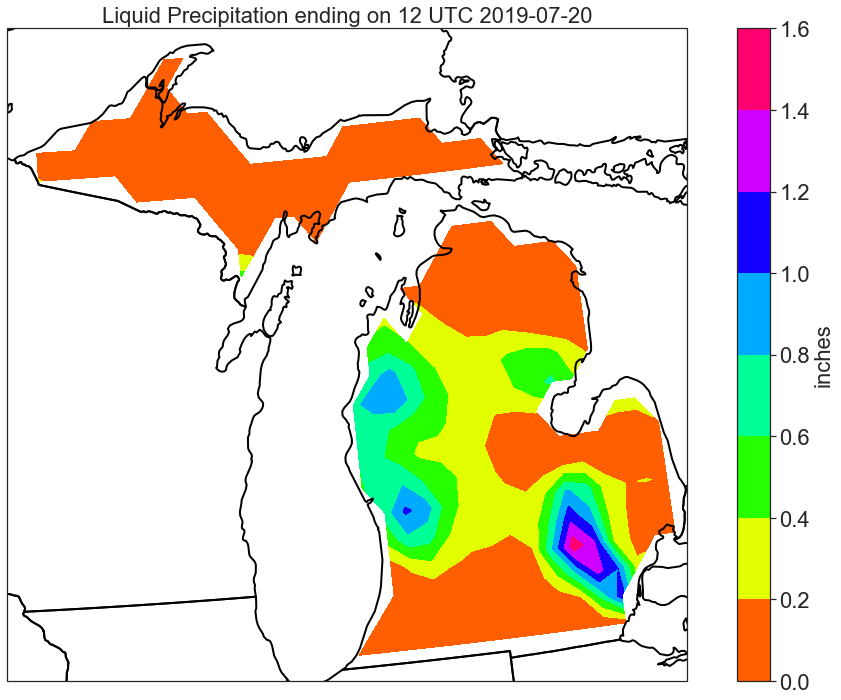

In [10]:
#Make a contour plot of the daily data using Matplotlib

fig = plt.figure(figsize=(18,12))

proj = ccrs.LambertConformal(standard_parallels=[33,45])
ax = plt.axes(projection=proj)
ax.add_feature(cfeature.STATES,linewidth=2.0)
ax.set_title('Liquid Precipitation ending on 12 UTC %s' % date, fontsize=22)

cs = ax.contourf(prcp_masked['lon'],prcp_masked['lat'],prcp_masked[:,:,0]*0.0393701, cmap='hsv', transform=ccrs.PlateCarree())
cb = plt.colorbar(cs, ax=ax)
cb.ax.tick_params(labelsize=22) 
cb.set_label('inches', size=22)
plt.show()

In [11]:
#Create a new data array that includes only the precip data over Michigan for all times 1948-present
#Then take the means at each point over the entire 

prcp_masked_all = daily_prcp_xr["precip"].sel(lon=slice(aoi_lon[0], aoi_lon[1]), lat=slice(aoi_lat[0], aoi_lat[1])).where(mi_mask)
prcp_masked_mean = prcp_masked_all.mean(axis=0)

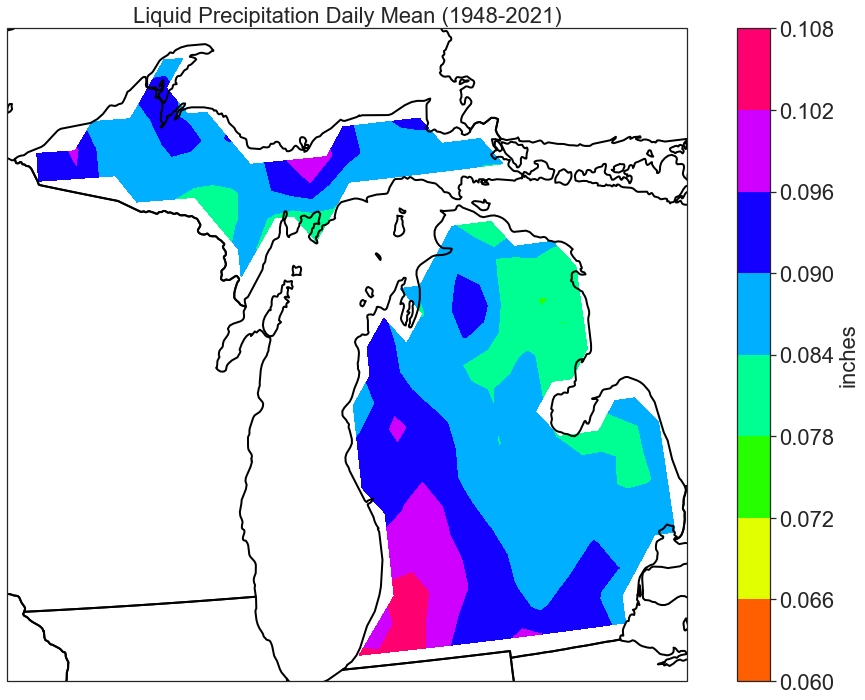

In [12]:
#Make a contour plot of the mean data using Matplotlib

fig = plt.figure(figsize=(18,12))

proj = ccrs.LambertConformal(standard_parallels=[33,45])
ax = plt.axes(projection=proj)
ax.add_feature(cfeature.STATES,linewidth=2.0)
ax.set_title('Liquid Precipitation Daily Mean (1948-2021)', fontsize=22)

cs = ax.contourf(prcp_masked_mean['lon'],prcp_masked_mean['lat'],prcp_masked_mean[:,:,0]*0.0393701, cmap='hsv', transform=ccrs.PlateCarree())
cb = plt.colorbar(cs, ax=ax)
cb.ax.tick_params(labelsize=22) 
cb.set_label('inches', size=22)
plt.show()

In [14]:
#From all the data, replace all nonzero values with NaN, leaves us with only days with rain

nozero = prcp_masked_all.where(prcp_masked_all[:,:,:]>0)

#Group the data by year and take the average of the year, using only days with rain

prcp_masked_yrly_mean = nozero.groupby("time.year").mean()

#Group the data by year and sum up the values for each year, using only days with rain

prcp_masked_yrly_total = nozero.groupby("time.year").sum()

#Average the total annual precipitation across all points in Michigan

prcp_masked_yrly_mean_state = prcp_masked_yrly_total.mean(dim=['lat','lon'])

#Select year 2019 for plotting

mean_precip_2019 = prcp_masked_yrly_mean.sel(year=2019)

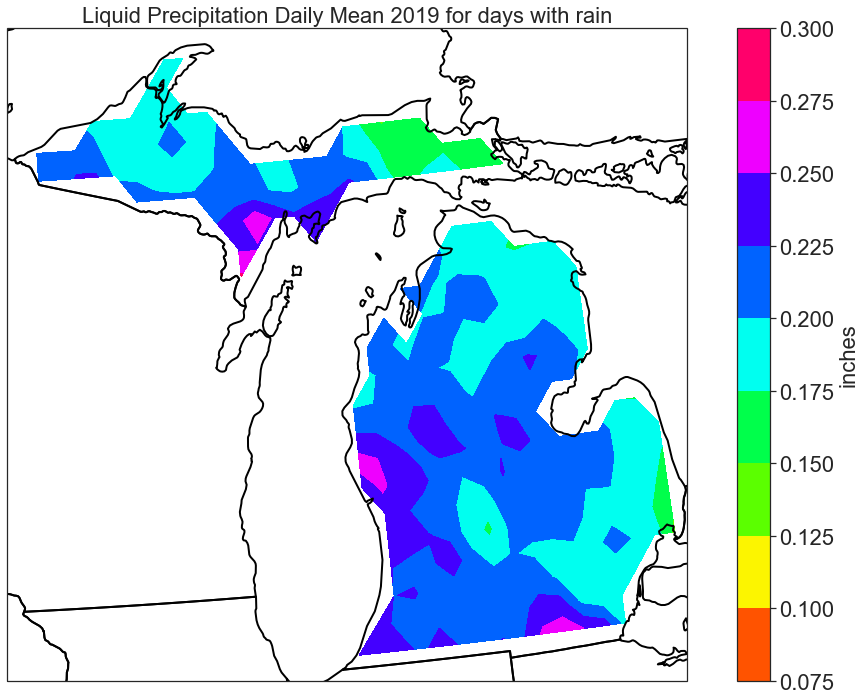

In [16]:
#Make a contour plot of the mean 2019 data for data with only days where rain occurred

fig = plt.figure(figsize=(18,12))

proj = ccrs.LambertConformal(standard_parallels=[33,45])
ax = plt.axes(projection=proj)
ax.add_feature(cfeature.STATES,linewidth=2.0)
ax.set_title('Liquid Precipitation Daily Mean 2019 for days with rain', fontsize=22)

cs = ax.contourf(mean_precip_2019['lon'],mean_precip_2019['lat'],mean_precip_2019[:,:,0]*0.0393701, cmap='hsv', transform=ccrs.PlateCarree())
cb = plt.colorbar(cs, ax=ax)
cb.ax.tick_params(labelsize=22) 
cb.set_label('inches', size=22)
plt.show()

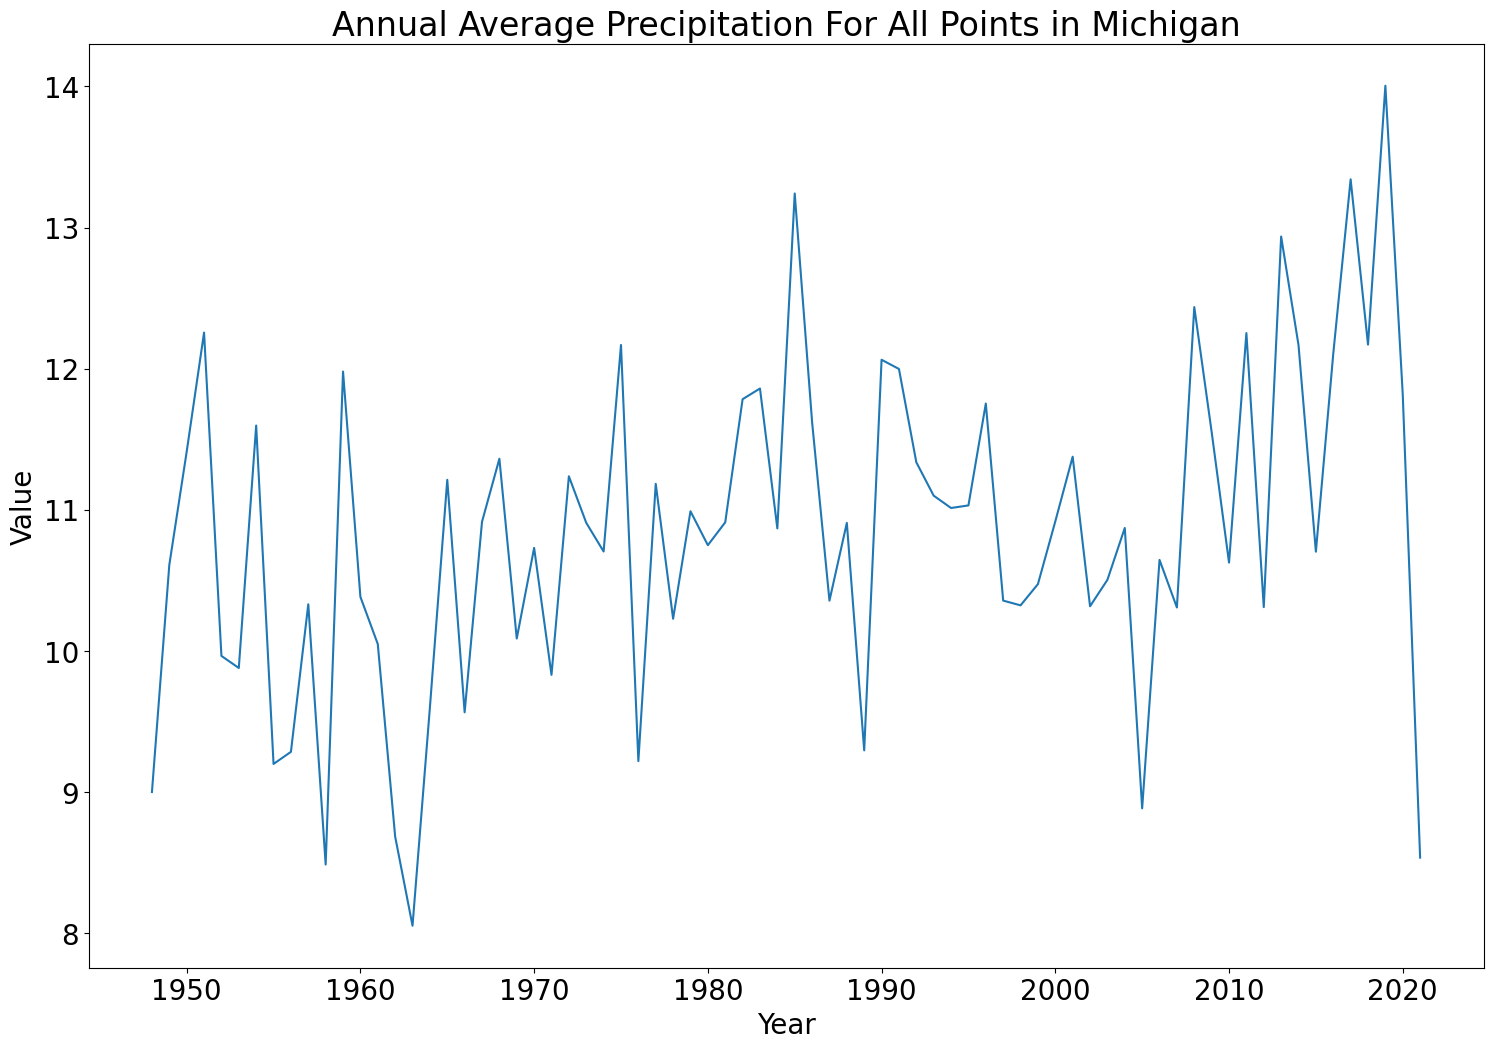

In [29]:
#Make a time series plot of the average annual precipitation for the whole state

plt.rcParams.update({'font.size':20})
plt.figure(figsize=(18,12))
plt.plot(prcp_masked_yrly_mean_state['year'], prcp_masked_yrly_mean_state[:]*0.0393701)
plt.xlabel('Year')
plt.ylabel('Value')
plt.title("Annual Average Precipitation For All Points in Michigan")
plt.show()